# 平均に隠れた本音を暴く。混合モデルによる顧客満足度構造の深堀り
「満足度 3.1 点」という平均値の裏側には、「熱狂的なファン」と「静かな不満層」が混在している可能性があります。
この「声なき多層構造」をベイズで可視化し、商品・サービス改善の真の優先順位を特定します。

## ユースケース
新商品発売やサービスのリニューアル後、アンケート結果が「中途半端な平均値」に落ち着いてしまい、次の一手に迷っています。

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pymc as pm
import arviz as az
import pytensor.tensor as pt

warnings.filterwarnings("ignore")

In [2]:
# Color Identity
COLOR_PURPLE = "#985DE5"
COLOR_BLUE   = "#118AB2"
COLOR_GREEN  = "#06D6A0"
COLOR_YELLOW = "#F9C74F"
COLOR_RED    = "#EF476F"
COLOR_GRAY   = "#8D99AE"

plt.rcdefaults()  # plt の現在のカラー定義をリセット
palette_brand = [COLOR_PURPLE, COLOR_BLUE, COLOR_GREEN, COLOR_YELLOW, COLOR_RED, COLOR_GRAY]

sns.set_theme(style="whitegrid", palette=palette_brand)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_brand)

In [3]:
# 可視化時に日本語を表示可能にする
import japanize_matplotlib

plt.rcParams["font.family"] = "IPAexGothic"

In [4]:
# Data の生成: 満足層(75%)と隠れ不満層(25%)の混合
np.random.seed(42)

n_obs = 40
results_survey = np.concatenate([
    np.random.normal(3.8, 0.7, int(n_obs * 0.75)),  # 満足層（ボリューム大、バラツキ大）
    np.random.normal(1.5, 0.4, int(n_obs * 0.25)),  # 隠れ不満層（ボリューム小、極端に低い）
])
# シャッフルして５段階評価にクリップ
np.random.shuffle(results_survey)
results_survey = np.clip(results_survey, 1.0, 5.0)

In [5]:
results_survey.mean()  # 観測データの平均を出力

np.float64(3.1030907747941225)

アンケート結果が、最も「中途半端な平均値」に落ち着いてしまっています。

## ビジネス課題の定義
### 背景
新商品リリース後のアンケート結果は、平均3.1点。従来のアプローチであれば「全体的に満足度は普通」と結論づけ、平均点を底上げする無難な施策が打たれがちです。

### 現場の信念
しかし、カスタマーサクセス（CS）部門へのヒアリングから、**「アンケートの平均点には表れにくいが、サービスに対して明確かつ強い不満を抱えている『サイレントな失望層』が一定数、存在する気がする...」** という懸念（ドメイン知識）が提示されました。

## データ確認（EDA: Exploratory Data Analysis）
現場の懸念を念頭に置き、実際のデータ（）の分布を確認します。

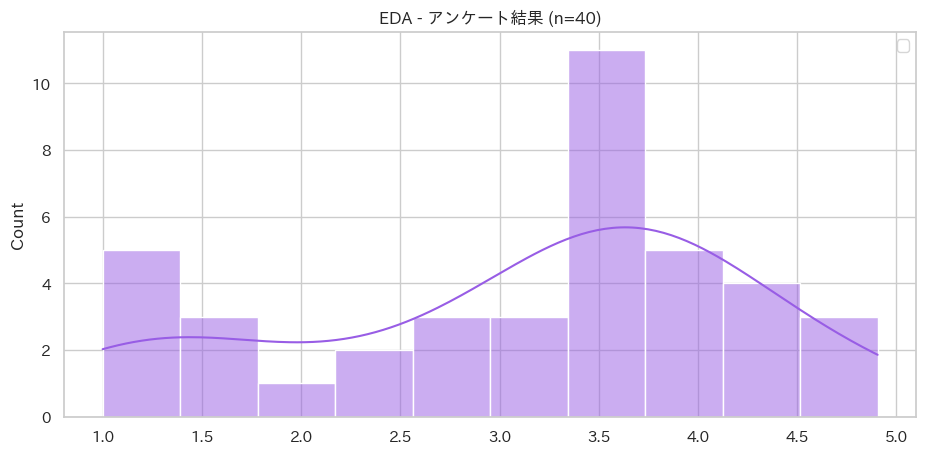

In [6]:
# ヒストグラムで分布を確認
plt.figure(figsize=(11, 5))
sns.histplot(results_survey, bins=10, kde=True)
plt.title(f"EDA - アンケート結果 (n={n_obs})")
plt.legend()
plt.show()

ヒストグラムを見ると、3〜4点に大きな山があり、1〜2点付近に少数のデータが存在しています。
単なるデータのバラツキ（外れ値）として処理されがちな微小なシグナルであるが、CSの「懸念」と照らし合わせると、これが「隠れた不満層」の尻尾である可能性が高そうです。

## 戦略的問い立て（OS の選択）
現場の懸念と、EDAで見えた微小なシグナルを統合し意思決定に繋げるための「問い」を立てます。
ここでは「単一の平均値」を求めるのではなく、顧客が「ポジティブ層」と「ネガティブ層」の2つの異なる集団から構成されているという仮説を立て、**「多様性の分離」** を行うことにしました。

**OS (エンジン)** : 個別データのバラツキを許容しつつ、全体の構造を捉える 階層ベイズの考え方を応用した混合モデル を採用します。


### OS (エンジン)
階層ベイズの考え方を応用した混合モデル

#### 選定根拠
1. 個性と共通性の共存 (階層性の応用)
    階層ベイズは「個別のデータの違い」を認めつつ、「全体としての共通性」も加味する手法です。混合モデルはこの考え方を応用し、「顧客一人ひとりは違うが、大きく分ければ数種類のタイプ（セグメント）に集約される」という仮説を構造化します。
    これにより、「個別のバラツキ」に惑わされず、「集団としての傾向」を安定して抽出が可能です。
2. 小規模データにおける「確信」の担保
    今回の $n=30$ というデータ量は、一般的な統計手法では「有意差なし」や「過学習」のリスクが高い領域です。
    - **事前知識の活用**: 「顧客には不満層がいるはずだ」というドメイン知見を事前分布として組み込むことで、少ないデータからでも効率的に構造を表現できます。
    - **不確実性の可視化** : 抽出されたセグメント比率 $w$ や平均値 $\mu$ を「点」ではなく「分布(幅)」として算出するため、経営者は「最悪のシナリオ」を想定した意思決定が可能になります。
3. 意思決定プロセス「期待効用」への直結
    混合モデルを選ぶ最大のビジネス的メリットは、「どのグループをターゲットにすべきか」が確率的に計算可能になる点です。
    - 単一の平均値モデルでは「全員に対して一律の施策」しか提案できません。
    - 混合モデル (OS)であれば、「40%の失望層を救う施策」と「60%の熱狂層を維持する施策」のそれぞれの投資対効果（期待効用） を天秤にかけることができます。

## ベジパタ OS 選定

カテゴリ | 問い立て(戦略的意図) | OS(エンジン) | デザインパターン | 意思決定プロセス | 推奨プロット
--- | --- | --- | --- | --- | ---
深堀 | 平均に隠れた特殊な集団はないか？ | 混合モデル | ⑬サイレント・マジョリティ | 期待効果(セグメント) | クラスター密度図

## 分析用データ加工
PyMCでの計算とビジネス上の解釈を繋ぐため、データに次元と座標（ラベル）を定義します。

In [7]:
# PyMC用の座標 (coords) と次元 (dims) の設定
coords = {
    "id_obs": np.arange(n_obs),
    "cluster": [
        "Disappointed",  # 失望層
        "Enthusiast"  # 熱狂層
    ]
}

## 確率モデルの構築
データの背後にある「生成プロセス」を数理モデルとして定義します。<br>
複数の正規分布を比率で混ぜ合わせた確率分布です。

In [8]:
with pm.Model(coords=coords) as model_mixture:
    # 構成比率 (w) の事前分布
    # ２つのセグメント(失望層・熱狂層）の比率を推定
    # a=[1, 1] は「どの比率も等しくあり得る（無情報）」という設定
    w_cluster = pm.Dirichlet("w_cluster", a=np.array([1, 1]), dims="cluster")

    # 平均 (mu) の事前分布: ラベルスイッチングを防ぐため初期値を分ける
    mu_cluster = pm.Normal("mu_cluster", mu=[2, 4], sigma=1, dims="cluster")
    sigma_cluster = pm.HalfNormal("sigma_cluster", sigma=1, dims="cluster")

    obs = pm.NormalMixture("obs", w=w_cluster, mu=mu_cluster,
                                   sigma=sigma_cluster, observed=results_survey,
                                   dims="id_obs")


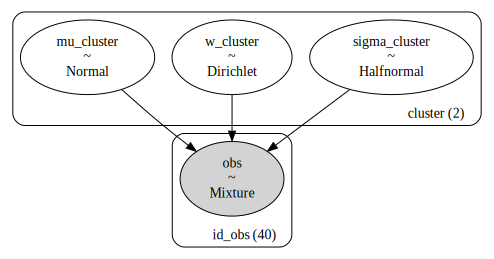

In [9]:
# 構築したモデルの可視化
pm.model_to_graphviz(model_mixture)

## 事前予測チェック (Prior Predictive Check)
現実的な範囲のデータを生成するか確認します。<br>
自分たちの作った数式モデルで、まともなデータが生成されるかテストします。

In [10]:
with model_mixture:
    # 事前予測サンプリング
    idata_prior = pm.sample_prior_predictive(samples=100, random_seed=42)

Sampling: [mu_cluster, obs, sigma_cluster, w_cluster]


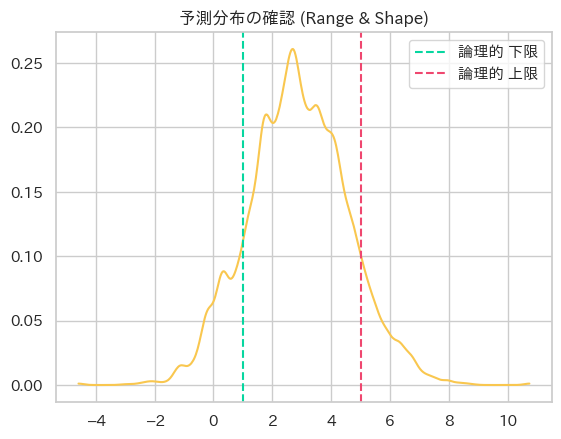

In [11]:
# 物理&論理的な「範囲」の確認
samples_prior = idata_prior.prior_predictive["obs"]
az.plot_dist(samples_prior, color=COLOR_YELLOW)
plt.axvline(1.0, linestyle="--", label="論理的 下限", color=COLOR_GREEN)
plt.axvline(5.0, linestyle="--", label="論理的 上限", color=COLOR_RED)
plt.title("予測分布の確認 (Range & Shape)")
plt.legend()
plt.show()

分布が -4 から 10 付近まで広がっています。
1. 満足度調査では「-2点」や「8点」という回答は、現実には存在しません。
2. モデルが「-4点もあり得る」と想定した状態でサンプリングを開始すると、実際のデータを説明するのに時間がかかったり、収束が不安定になる原因になります。

モデルのチューニングを行います。

In [12]:
# チューニング: sigma を絞る
with pm.Model(coords=coords) as model_mixture_v1:
    # 構成比率 (w) の事前分布
    # ２つのセグメント(失望層・熱狂層）の比率を推定
    # a=[1, 1] は「どの比率も等しくあり得る（無情報）」という設定
    w_cluster = pm.Dirichlet("w_cluster", a=np.array([1, 1]), dims="cluster")

    # 平均 (mu) の事前分布: ラベルスイッチングを防ぐため初期値を分ける
    mu_cluster = pm.Normal("mu_cluster", mu=[2, 4], sigma=0.5, dims="cluster")
    sigma_cluster = pm.HalfNormal("sigma_cluster", sigma=0.5, dims="cluster")

    obs = pm.NormalMixture("obs", w=w_cluster, mu=mu_cluster,
                                   sigma=sigma_cluster, observed=results_survey,
                                   dims="id_obs")

    idata_prior_v1 = pm.sample_prior_predictive(samples=100, random_seed=42)

Sampling: [mu_cluster, obs, sigma_cluster, w_cluster]


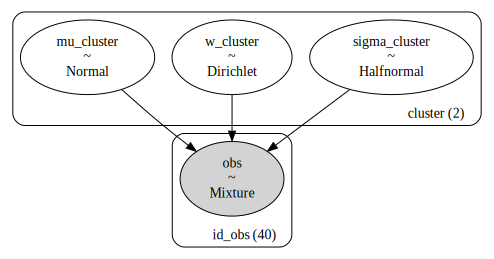

In [13]:
# 構築したモデルの可視化
pm.model_to_graphviz(model_mixture_v1)

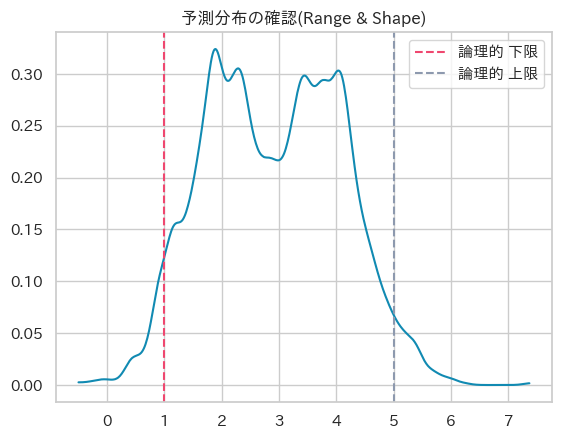

In [14]:
samples_prior_v1 = idata_prior_v1.prior_predictive["obs"]
az.plot_dist(samples_prior_v1, color=COLOR_BLUE)
plt.axvline(1.0, linestyle="--", label="論理的 下限", color=COLOR_RED)
plt.axvline(5.0, linestyle="--", label="論理的 上限", color=COLOR_GRAY)
plt.title("予測分布の確認(Range & Shape)")
plt.legend()
plt.show()

`sigma=0.5` によって分布の大部分が 1.0 ~ 5.0 の枠内に収まってきていますが物理・理論的に発生しない範囲外の回答が発生する可能性があります。

これ以上 sigma を絞ると、「各グループ内にはある程度の多様性（バラツキ）がある」という仮説まで否定することになり、モデルが窮屈になりすぎてしまいます。
正規分布を使っている以上、数学的に「裾（テール）」が無限に続くのは避けられません。

そこで、「無理に山を細くする」のではなく現在の 正規分布 (Normal) を、範囲外を物理的に許さない 截断正規分布 (Truncated Normal) に差し替えます。
>截断正規分布 (Truncated Normal Distribution)
>
>通常の正規分布 $N(\mu, \sigma^2)$ の確率密度関数に対し、指定した範囲 $[a, b]$ 外の確率を 0 とし、範囲内の面積が 1 になるよう再正規化した分布。
>
> $f(x|\mu, \sigma, a, b) = \frac{\phi(\frac{x-\mu}{\sigma})}{\sigma(\Phi(\frac{b-\mu}{\sigma}) - \Phi(\frac{a-\mu}{\sigma}))} \quad (a \le x \le b)$

In [15]:
# チューニング: 截断正規分布の採用
with pm.Model(coords=coords) as model_mixture_v2:
    # 比率の事前分布
    w_cluster = pm.Dirichlet("w_cluster", a=np.array([1, 1]), dims="cluster")

    # 平均と標準偏差
    # mu を [1, 5] に截断して安全に
    mu_cluster = pm.TruncatedNormal("mu_cluster", mu=[2, 4], sigma=0.5, lower=1, upper=5, dims="cluster")
    # sigma が 1.0 を超えるとグループ内のばらつきが極端になりすぎる
    sigma_cluster = pm.TruncatedNormal("sigma_cluster", mu=0, sigma=0.5, lower=0.05, upper=1.5, dims="cluster")

    # mu[0] < mu[1] を強制 -> ラベルスイッチングを構造的に防止
    pm.Potential("order_constraint", pm.math.switch(mu_cluster[0] < mu_cluster[1], 0, -np.inf))

    # 截断正規分布をコンポーネントとして定義
    dist_component = pm.TruncatedNormal.dist(mu=mu_cluster, sigma=sigma_cluster, lower=1, upper=5, shape=2)

    # 混合モデルの定義
    obs = pm.Mixture("obs", w=w_cluster, comp_dists=dist_component, observed=results_survey,
                             dims="id_obs")

- `mu` 自体も裁断
    mu_cluster ~ Normal(mu=[2, 4], sigma=0.5) は無截断なので、理論上 mu が 0 や 6 を取る確率がゼロではありません。
    截断正規分布の mu パラメータが定義域外に出ると、コンポーネントの確率密度が極端に歪み、サンプラーの効率が下がるリスクがあります。

- `sigma` のスケール感を明示する
    HalfNormal(sigma=0.5) は 95% が約 0〜1.0 に収まりますが、sigma > 1.5 といった値も稀に生成されます。
    1〜5 の 4 点幅のスケールでは sigma=1.5 は「ほぼ一様分布」に近く、グループの意味が薄れます。

- ラベルスイッチングを構造的に防止する
    事前平均 [2, 4] で「大体は分かれる」のですが、MCMC チェインが長い場合にスイッチする可能性はゼロではありません。
    明示的な順序制約を入れると安心です。


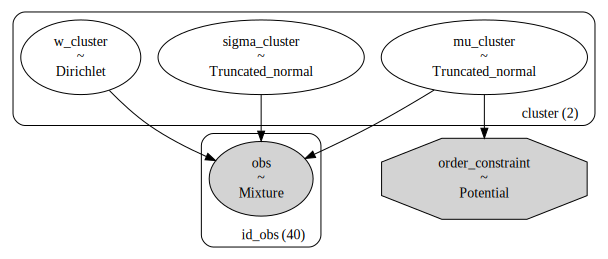

In [16]:
# 構築したモデルの可視化
pm.model_to_graphviz(model_mixture_v2)

In [17]:
# 事前予測サンプリング
with model_mixture_v2:
    idata_prior_v2 = pm.sample_prior_predictive(samples=100, random_seed=42)

Sampling: [mu_cluster, obs, sigma_cluster, w_cluster]


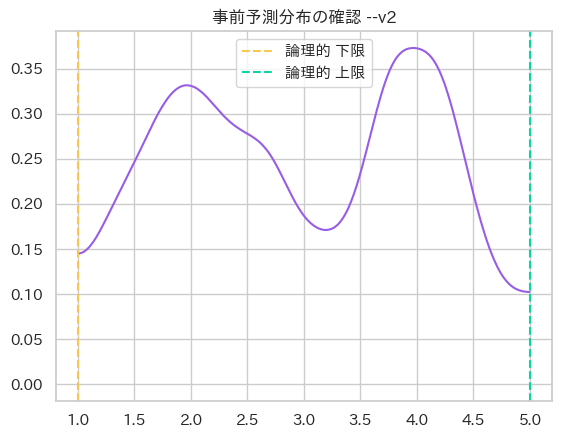

In [18]:
samples_prior_v2 = idata_prior_v2.prior_predictive["obs"]
az.plot_dist(samples_prior_v2, color=COLOR_PURPLE)
plt.axvline(1.0, linestyle="--", label="論理的 下限", color=COLOR_YELLOW)
plt.axvline(5.0, linestyle="--", label="論理的 上限", color=COLOR_GREEN)
plt.title("事前予測分布の確認 --v2")
plt.legend()
plt.show()

以下の３点が達成されました。
1. 境界の厳格性: 1.0 未満、5.0 超のサンプルが物理的に存在せず、ビジネス上の矛盾が解消されています。
2. 二峰性の維持: 2.0 付近と 4.0 付近に明確なピークがあり、「サイレント・マジョリティ」を分離する準備が整っています。
3. 確信の「幅」: 山の裾野が広すぎず、かつ平坦すぎないため、実際のデータ（$n=40$）が持つ情報を吸収するのに最適な「柔軟な予習」になっています。

## モデル・デバック
MCMCサンプリングを開始する前に、モデルの初期状態に数学的矛盾（対数尤度が -inf になる等）がないかを点検する。

`.point_logps()` でモデル内の各ノード（確率変数）において、対数尤度 $\log P(D|\theta)$ や対数事前確率 $\log P(\theta)$ が有限な値（Finite）として計算できているかを検証します。

In [19]:
# 各変数の初期対数尤度の確認（命名規則を厳守）
model_mixture_v2.point_logps()

{'w_cluster': np.float64(-0.69),
 'mu_cluster': np.float64(-4.41),
 'sigma_cluster': np.float64(-3.33),
 'obs': np.float64(-69.31),
 'order_constraint': np.float32(-inf)}

`order_constraint` が `-inf`（マイナス無限大）である状態は「問題あり」です。
モデルが計算を開始しようとした瞬間に、たまたま mu_cluster[0] が mu_cluster[1] 以上の値になってしまいこのまま pm.sample() を実行しても、初期値が「確率 0（不可能）」な地点に立っているため、
サンプラーが 1 歩も動けずエラーで停止してしまう可能性があります。

`initval` で初期値を明示的に指定しすることで対応します。

In [20]:
# チューニング: initval の設定
with pm.Model(coords=coords) as model_mixture_v3:
    w_cluster = pm.Dirichlet("w_cluster", a=np.array([1, 1]), dims="cluster")

    mu_cluster = pm.TruncatedNormal("mu_cluster",
                                    mu=[2, 4], sigma=0.5, lower=1, upper=5, dims="cluster", initval=[1.5, 3.8])  # 追加
    sigma_cluster = pm.TruncatedNormal("sigma_cluster",
                                       mu=0.5,  # mu=0 より少し浮かせて安定させる
                                       sigma=0.5, lower=0.05, upper=1.5, dims="cluster")

    # ラベルスイッチングの構造的防止
    pm.Potential("order_constraint", pm.math.switch(mu_cluster[0] < mu_cluster[1], 0, -np.inf))

    # 截断正規分布をコンポーネントとして定義し、混合モデルを構築
    dist_component = pm.TruncatedNormal.dist(mu=mu_cluster, sigma=sigma_cluster, lower=1, upper=5, shape=2)
    obs = pm.Mixture("obs", w=w_cluster, comp_dists=dist_component, observed=results_survey,
                             dims="id_obs")

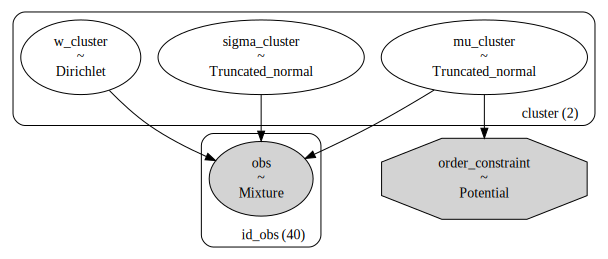

In [21]:
# 構築したモデルの可視化
pm.model_to_graphviz(model_mixture_v3)

In [22]:
model_mixture_v3.point_logps()

{'w_cluster': np.float64(-0.69),
 'mu_cluster': np.float64(-1.99),
 'sigma_cluster': np.float64(-2.32),
 'obs': np.float64(-56.03),
 'order_constraint': np.float32(0.0)}

`'order_constraint'` が `0.0` になり解消しました。
念の為、事前予測を再チェックしてみます。

In [23]:
with model_mixture_v3:
    idata_prior_v3 = pm.sample_prior_predictive(samples=100, random_seed=42)

Sampling: [mu_cluster, obs, sigma_cluster, w_cluster]


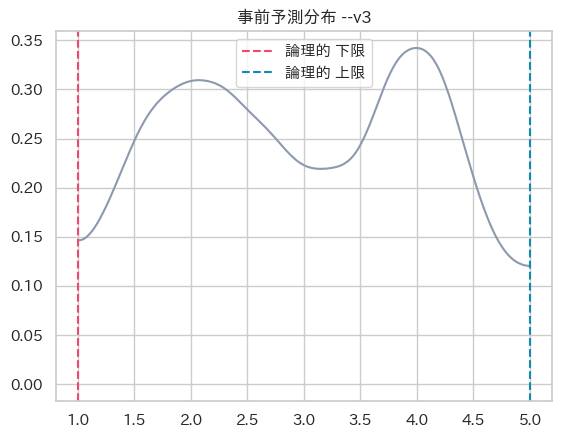

In [24]:
samples_prior_v3 = idata_prior_v3.prior_predictive["obs"]
az.plot_dist(samples_prior_v3, color=COLOR_GRAY)
plt.axvline(1.0, linestyle="--", label="論理的 下限", color=COLOR_RED)
plt.axvline(5.0, linestyle="--", label="論理的 上限", color=COLOR_BLUE)
plt.title("事前予測分布 --v3")
plt.legend()
plt.show()

- 境界値
- 二峰姓
- 幅

に問題ないを確認しました。

## 推論（MCMCサンプリング）
いよいよベイズ推論を行います。小規模データのため、サンプラーの慎重さ（`target_accept`）を高めに設定しています。

In [25]:
with model_mixture_v3:
    idata_posterior = pm.sample(draws=2000,  # 推論結果（事後分布）として最終的に採用・記録するサンプル数
                                tune=1000,  # 本番前の「ウォーミングアップ」の数
                                chains=4,  # 独立して走らせるシミュレーションの数
                                target_accept=0.95,  # サンプラーの「慎重（目標採択率）」
                                random_seed=42)  # 乱数の生成パターン

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_cluster, mu_cluster, sigma_cluster]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


発散してしまいました。
今回のモデルの発散が起きやすいポイントは主に3つです：
1. pm.Potential による硬い制約境界 — mu[0] < mu[1] の違反時に -inf を返すため、境界付近でサンプラーの曲率が急変する
2. TruncatedNormal の上下限境界 — パラメータが境界に近づくと勾配が不安定になりやすい
3. 混合モデル固有の多峰性 — 重み w が小さいコンポーネントは尤度面が平坦で勾配情報が乏しくなる

以下のチューニングを行ってみます。
1. `target_accept` の引き上げ + `tune` の増加
2. 順序制約の「ソフト化」(`orderd transform` で代替)
    現在の pm.Potential は -inf という硬い壁なので、境界付近で勾配が発散します。これを滑らかなペナルティに置き換えると、サンプラーにとって「優しい地形」になります

In [26]:
# チューニング: 順序制約の「ソフト化」
with pm.Model(coords=coords) as model_mixture_v4:
    w_cluster = pm.Dirichlet("w_cluster", a=np.array([1, 1]), dims="cluster")

    mu_cluster = pm.TruncatedNormal("mu_cluster",
                                    mu=[2, 4],
                                    sigma=0.5,
                                    lower=1,
                                    upper=5,
                                    dims="cluster",
                                    initval=[1.5, 3.8],
                                    )  # 追加
    sigma_cluster = pm.TruncatedNormal("sigma_cluster",
                                       mu=0.5,  # mu=0 より少し浮かせて安定させる
                                       sigma=0.5, lower=0.05, upper=1.5, dims="cluster")

    pm.Potential("order_constraint", pm.logp(pm.Normal.dist(mu=0, sigma=0.1),
                                             mu_cluster[1] - mu_cluster[0])
                 if False else
                 -1000 * pt.max([0, mu_cluster[0] - mu_cluster[1]])
                 )

    # 截断正規分布をコンポーネントとして定義し、混合モデルを構築
    dist_component = pm.TruncatedNormal.dist(mu=mu_cluster, sigma=sigma_cluster, lower=1, upper=5, shape=2)
    obs = pm.Mixture("obs", w=w_cluster, comp_dists=dist_component, observed=results_survey,
                             dims="id_obs")

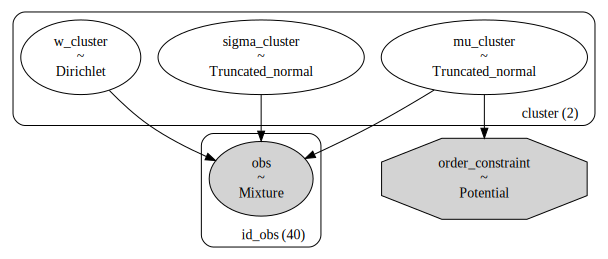

In [27]:
# 構築したモデルの可視化
pm.model_to_graphviz(model_mixture_v4)

In [28]:
model_mixture_v4.point_logps()

{'w_cluster': np.float64(-0.69),
 'mu_cluster': np.float64(-1.99),
 'sigma_cluster': np.float64(-2.32),
 'obs': np.float64(-56.03),
 'order_constraint': np.float64(-0.0)}

In [29]:
# 再推論
with model_mixture_v4:
    idata_posterior = pm.sample(2000, tune=2000, target_accept=0.98, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_cluster, mu_cluster, sigma_cluster]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


まだ発散してしまう為、非中心化パラメトリゼーションを行ってみます。

In [30]:
# チューニング: 非中心化パラメトリゼーション
with pm.Model(coords=coords) as model_mixture_v5:
    # # --- 構成比率 ---
    w_cluster = pm.Dirichlet("w_cluster", a=np.array([1, 1]), dims="cluster")

    # 非中心化: mu
    mu_offset = pm.Normal("mu_offset", mu=0, sigma=1, dims="cluster")
    mu_base = np.array([2.0, 4.0])  # 事前の広がり
    mu_scale = 0.5  # 事前の広がり
    mu_cluster = pm.Deterministic(  # ★ ここで元の空間に変換＆記録
        "mu_cluster",
        pt.clip(mu_base + mu_offset * mu_scale, 1, 5),
        dims="cluster"
    )

    # --- 非中心化: sigma ---
    sigma_offset = pm.HalfNormal("sigma_offset", sigma=1, dims="cluster")
    mu_sigma = 0.5,  # mu=0 より少し浮かせて安定させる
    sigma_cluster = pm.Deterministic(
        "sigma_cluster",
        pt.clip(mu_sigma + sigma_offset * 0.3, 0.05, 1.5),
        dims="cluster"
    )

    # --- 順序制約（ソフト化） ---
    pm.Potential("order_constraint", pm.logp(pm.Normal.dist(mu=0, sigma=0.1),
                                             mu_cluster[1] - mu_cluster[0])
    if False else
    -1000 * pt.max([0, mu_cluster[0] - mu_cluster[1]])
                 )

    # 截断正規分布をコンポーネントとして定義し、混合モデルを構築
    dist_component = pm.TruncatedNormal.dist(
        mu=mu_cluster, sigma=sigma_cluster, lower=1, upper=5, shape=2)

    obs = pm.Mixture("obs", w=w_cluster, comp_dists=dist_component, observed=results_survey, dims="id_obs")

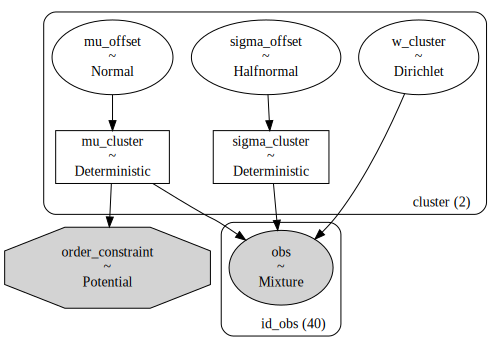

In [31]:
# 構築したモデルの可視化
pm.model_to_graphviz(model_mixture_v5)

In [32]:
model_mixture_v5.point_logps()

{'w_cluster': np.float64(-0.69),
 'mu_offset': np.float64(-1.84),
 'sigma_offset': np.float64(-1.45),
 'obs': np.float64(-56.92),
 'order_constraint': np.float64(-0.0)}

In [33]:
# 再推論
with model_mixture_v5:
    idata_posterior = pm.sample(2000, tune=2000, target_accept=0.98, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_cluster, mu_offset, sigma_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.


In [34]:
# 推論に成功した為、推論データを保存
dir_models = "models"
os.makedirs(dir_models, exist_ok=True)
PATH_INFERENCE_DATA = os.path.join(dir_models, "inference_mixture_v5.nc")

az.to_netcdf(idata_posterior, PATH_INFERENCE_DATA)

'models/inference_mixture_v5.nc'

## 推論結果の診断
4つの独立した推論（`Chain`）が同じ答え（事後分布）に辿り着いたか、数学的に診断します。

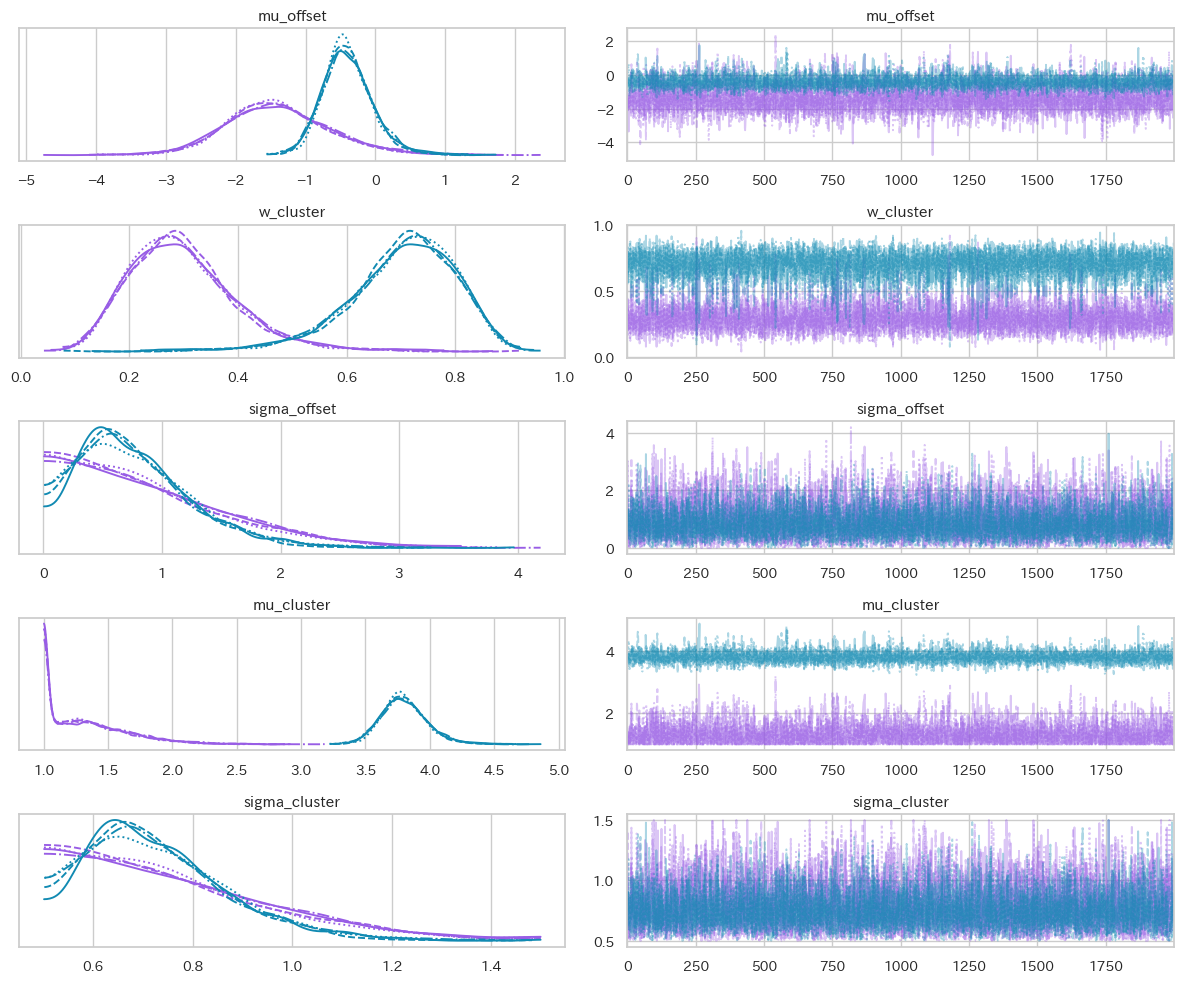

In [35]:
# 収束具合の可視化
az.plot_trace(idata_posterior, compact=True)  # 確認指標が多いため compact=True で可視化します
plt.tight_layout()
plt.show()

- 左図: 各Chain の分布がほぼ綺麗に重なっています。
- 右図: 綺麗な毛虫状になっています。

問題なく収束していそうです。

In [36]:
# R-hat 等の数学的指標を確認します。
az.summary(idata_posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_offset[Disappointed],-1.386,0.757,-2.749,0.104,0.014,0.012,3052.0,2937.0,1.0
mu_offset[Enthusiast],-0.398,0.366,-1.042,0.307,0.006,0.006,4304.0,3398.0,1.0
w_cluster[Disappointed],0.298,0.101,0.122,0.480,0.002,0.002,3551.0,3370.0,1.0
w_cluster[Enthusiast],0.702,0.101,0.520,0.878,0.002,0.002,3551.0,3370.0,1.0
sigma_offset[Disappointed],0.884,0.678,0.000,2.120,0.012,0.008,2397.0,1882.0,1.0
sigma_offset[Enthusiast],0.765,0.483,0.002,1.610,0.008,0.006,2918.0,1765.0,1.0
mu_cluster[Disappointed],1.344,0.325,1.000,1.928,0.006,0.006,2980.0,2937.0,1.0
mu_cluster[Enthusiast],3.801,0.183,3.479,4.154,0.003,0.003,4304.0,3398.0,1.0
sigma_cluster[Disappointed],0.765,0.203,0.500,1.136,0.004,0.002,2395.0,1882.0,1.0
sigma_cluster[Enthusiast],0.729,0.145,0.501,0.983,0.002,0.002,2918.0,1765.0,1.0


- r_hat($\hat{R}$: 収束診断指標)が1.01未満。
- ess_bulk(平均の推定のキレ)が 400以上
- ess_tail(極端な値の正確性)が 400以上

上記より数学的指標からも問題なく推論できていると確認出来ました。

## 事後予測チェック
推定されたモデル（事後分布）を使ってデータを再生成しヒストグラムの形状を「モデルが正しく模倣できているか」を検証します。

Sampling: [obs]


Output()

<Figure size 1100x500 with 0 Axes>

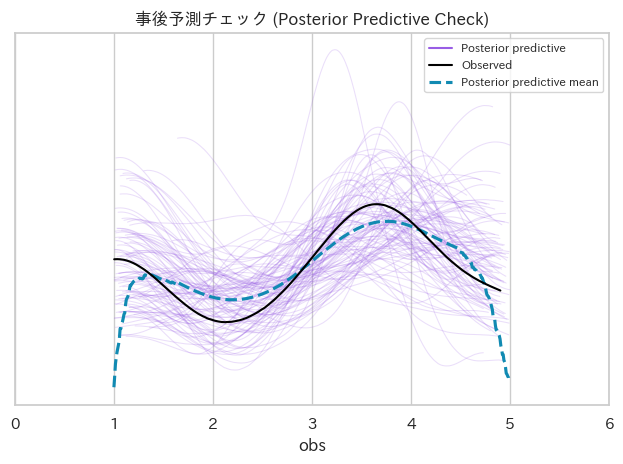

In [37]:
with model_mixture_v5:
    # 事後予測サンプリング
    # 推論済みのモデルとデータ(idata_posterior)を使ってデータを再生成します
    pm.sample_posterior_predictive(idata_posterior, extend_inferencedata=True, random_seed=42)

# 実際のデータと予測データの分布を重ねて可視化
plt.figure(figsize=(11, 5))
az.plot_ppc(idata_posterior, num_pp_samples=100, random_seed=42)
plt.title("事後予測チェック (Posterior Predictive Check)")
plt.xlim(0, 6)
plt.tight_layout()
plt.show()

### 各線の意味
このグラフは、「現実のデータ」と「構築した確率モデルで生成したシミュレーション」の答え合わせ を行っています。

- **白い実線（Observed）**
「現実のアンケート結果」 です。
EDA で確認したヒストグラムの輪郭を滑らかな線（カーネル密度推定）にしたものです。1.5付近に小さなコブ、3.8付近に大きな山があります。

- **紫の無数の細い線（Posterior predictive）**
「構築した確率モデルの事後分布から生成したシミュレーションデータ」 です。
推論結果に基づいて「こういうデータが発生するはずだ」と何百回も予測した結果です。
線の広がりは、予測の「不確実性（ばらつき）」を表します。

- **水色の太い破線（Posterior predictive mean）**
「構築した確率モデルの事後分布から生成した予測の平均値（中心）」 です。
紫の細い線を平均化した、モデルの最も期待される形状を示しています。

### 解釈
1. 「水色の破線が、白い実線をなぞっているか？」 を注視します。
右側の大きな山（満足層）はもちろんのこと、左側の小さなコブ（失望層）の起伏までも、水色の破線が追従できています。
もし、最初に「単一の正規分布」でモデルを組んでいた場合、水色の線は3.2点付近を頂点とする「のっぺりとした1つの釣り鐘方」になり 1.5点の峰は完全に無視されていたはずです。この図は、「多様性の分離（混合モデル）」という選択を数学的に強固にしてくれています。
2. EDAの段階では「単なる数人のクレーマー（外れ値）」として片付けられそうだった低いスコアが、このプロットにより **「偶然ではなく、構造（クラスター）を持った集団である」と確度を大きくあげたことになります。
ステークホルダーに対して、「これは単なるデータのブレではなく、モデルが『明確な顧客層がここにある』と警告しています。」** と、説得力を持って報告できる状態になります。

<Figure size 700x500 with 0 Axes>

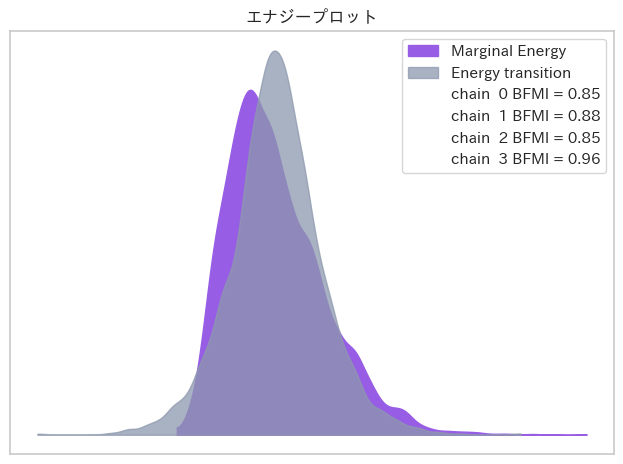

In [38]:
# エナジープロット
plt.figure(figsize=(7, 5))
az.plot_energy(idata_posterior)
plt.title("エナジープロット")
plt.tight_layout()
plt.show()

#### エナジープロット
出力されたグラフには、 **2つの分布（線）**が描かれます。

##### Marginal Energy（周辺エネルギー分布）
パラメータ空間全体の「地形の複雑さ（ポテンシャルエネルギー）」を示します。

##### Energy Transition（エネルギー遷移分布）
サンプラー（調査員）が1歩進むごとに、どれくらいスムーズに地形を移動できたか（運動エネルギー）を示します。

> ##### 定義】
HMC（ハミルトニアン・モンテカルロ）におけるエネルギーの保存則を評価するものです。
理想的なサンプリングが行われている場合、これら2つの分布（Marginal と Transition）はほぼ完全に重なり合います。

「サンプラー(調査員)が、山の斜面を引っかからずにスムーズに歩き回れたか」のようなイメージになります。
- **合格（重なっている）** : サンプラーが山の麓から頂上まで、くまなく探索できた（サンプリングは高効率で信頼できる）。
- **不合格（大きくズレている / Marginalの方が極端に広い）** : サンプラーが特定の深い谷底にハマってしまい、山全体を十分に探索しきれなった（推論結果に偏りがある可能性がある）。


もしこの2つの線が大きくズレている場合（特に複雑な階層モデルや混合モデルで起こりやすいです）、サンプラーの慎重さである target_accept をさらに高くする（例: 0.99）か、事前分布の初期値などを再チューニングする必要があります。

今回のモデルは、截断正規分布や順序制約を入れて構造を安定させているため、綺麗な一致が見られています。

## 意思決定プロセスの実行
推論されたパラメータ（事後分布）を用いて、データの背後に隠れていた「真の構造」を視覚化します。

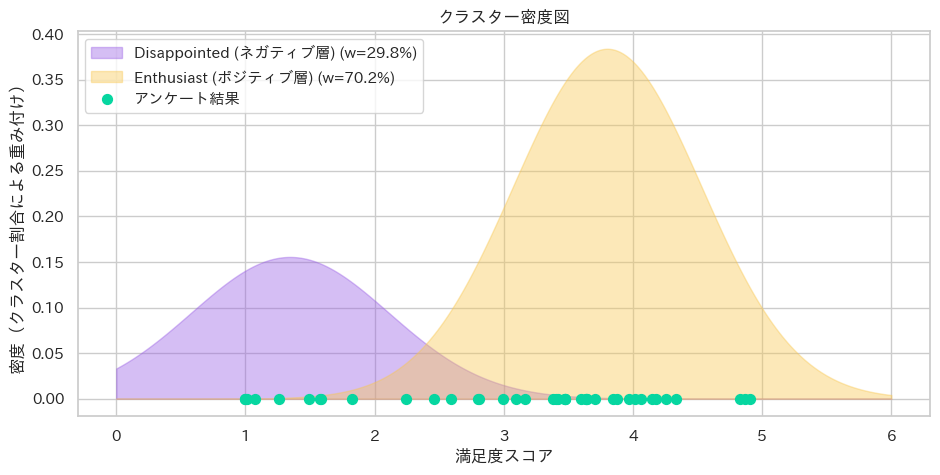

In [39]:
# クラスター密度図

# 事後分布から各パラメータの平均値を取得（推論結果の代表値）
post_w = idata_posterior.posterior["w_cluster"].mean(dim=["chain", "draw"]).values
post_mu = idata_posterior.posterior["mu_cluster"].mean(dim=["chain", "draw"]).values
post_sigma = idata_posterior.posterior["sigma_cluster"].mean(dim=["chain", "draw"]).values

x = np.linspace(0, 6, 500)
plt.figure(figsize=(11, 5))
colors = [COLOR_PURPLE, COLOR_YELLOW]
labels = ["ネガティブ層", "ポジティブ層"]

# 推定された２つのグループの分布を描画
for i, name in enumerate(coords["cluster"]):
    y = post_w[i] * (1 / (post_sigma[i] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - post_mu[i]) / post_sigma[i]) ** 2)
    plt.fill_between(x, y, alpha=0.4, color=colors[i], label=f"{name} ({labels[i]}) (w={post_w[i]:.1%})")

plt.scatter(results_survey,
            np.zeros_like(results_survey),
            color=COLOR_GREEN,
            s=50,
            zorder=5,
            label="アンケート結果")

plt.title("クラスター密度図")
plt.xlabel("満足度スコア")
plt.ylabel("密度（クラスター割合による重み付け）")
plt.legend()
plt.show()

### 1. 2つの山（事後分布）
推論の結果得られた、各グループの満足度スコアの確率密度分布です。山の高さはそのスコア周辺に顧客が集中している度合い（確信度）を示します。
山が 2 つあることは、顧客の満足度が 1 つの「普通（平均）」に集まっているのではなく、二つに分かれていることを証明しています。

つまり、今回のアンケート結果は、全体の平均点だけを見れば「3点台前半であり、全体的にまずまずの評価」と見誤る危険な状態でした。
しかし、混合分布モデルを用いて顧客の評価構造を分離した結果、顧客は「1つの平均的な集団」ではなく「全く異なる評価軸を持つ2つの集団」に明確に分断されていることが判明しました。

### 2. 重み（：比率）
**凡例の**各グループが全体に占める推定比率です。
全顧客 40 人のうち、約 28 人がポジティブ層、12 人がネガティブ層という勢力図が見えてきました。
- **ポジティブ層（約70.2%）**
    顧客の約7割は、平均3.8点という高い満足度を示しています。
    現在のプロダクト・サービスの価値は、市場の大多数に好意的に評価されている解釈できます。
- **ネガティブ層（約29.8%）**
    一方で、残りの約 3割の顧客は、平均1.5点という強い不満を抱えています。
    彼らの声は、7割のポジティブな声に埋もれていたと言えます。

### 3. プロット（アンケート結果：緑の点）
実際に観測されたの生データ（アンケート結果）になります 。
シミュレーションの結果（山）が、実際の点（事実）をしっかり覆っていることから、このモデルが現実を正しく捉えていることが分かります 。

## ビジネスインパクト
この約3割のネガティブ層は強いペインを抱えている可能性があります。
この層を放置することは、**高確率でのチャーン（解約・離脱）** を招くだけでなく、SNS等でのネガティブな口コミによるブランド毀損の火種となる可能性があります。
「全体の平均点を4点に上げる」といった全体施策ではなく、ターゲットを明確に分けた戦略が有効と考えます。

##  推奨アクションの提案案

顧客が二極化している以上、施策も**「守り」**と**「攻め」**の二段構えで実行することが有効であると考えます。

### 1. 【守り】 ネガティブ層（約30%）の「止血」と原因究明

平均1.5点をつけている顧客は、何かしらの「致命的な体験」をしています。この顧客層を救い出すことが最優先課題です。
- **属性の特定（Who）**: アンケートデータと顧客データベースを突合し、ネガティブ層の共通属性（例：特定プランの契約者、利用開始から1ヶ月未満、特定の流入経路など）を調査します。
- **ペインの深堀り（What/Why）**: 該当顧客に対して、CS（カスタマーサクセス）部門から優先的に個別ヒアリングやアウトバウンドコールを実施し、「どこでつまずいたのか（オンボーディングの失敗か、特定機能のバグか、期待値のズレか）」を特定します。
- **即時リカバリー（How）**: 個別のサポート対応や、不満を解消するためのチュートリアルの改善など、ピンポイントな消火活動を行います。

### 2. 【攻め】 ポジティブ層（約70%）の「価値最大化」
7割の顧客には現状の価値が提供できているため、ネガティブ層に引っ張られて **「プロダクトの根本的な仕様を変更する」ことは避けるべき**です（ポジティブ層を冷めさせるリスクがあります）。
- **LTVの向上**: 現状のサービス提供を維持しつつ、彼らに対して上位プランへのアップセルや、クロスセルの提案を行います。
- **アンバサダー化**: ロイヤリティの高いこの層に向けた「紹介キャンペーン（リファラル施策）」や、「導入事例（ケーススタディ）への登壇依頼」などを行い、新たな顧客獲得の原動力とします。